# 🌲 Capítulo 2 – Detección de Anomalías con Isolation Forest

En este segundo capítulo, se explorará el algoritmo **Isolation Forest**, una técnica de detección de anomalías no supervisada basada en principios estadísticos y estructurales. Su principal ventaja es que no requiere etiquetas ni entrenamiento supervisado, lo cual lo convierte en un candidato ideal para escenarios como el presente, donde no se dispone de información fiable sobre qué puntos son normales y cuáles no.

Isolation Forest se basa en la idea de que los puntos anómalos, al estar menos integrados en la distribución general de los datos, pueden aislarse más fácilmente a través de divisiones aleatorias del espacio de características. Este enfoque, si bien simple en su formulación, ha demostrado ser sorprendentemente eficaz y escalable en una amplia variedad de contextos industriales.

---

## 🎯 ¿Por qué Isolation Forest?

La elección de Isolation Forest en esta fase inicial del proyecto responde a varios motivos:

- Es un modelo **ligero, interpretable y rápido de entrenar**, ideal para exploración temprana.
- No necesita etiquetas ni conocimiento experto previo.
- Puede aplicarse directamente sobre datos multivariados sin requerir grandes transformaciones.
- Ha sido ampliamente utilizado en entornos industriales y de ingeniería de sistemas, lo que aporta cierta confianza sobre su aplicabilidad.

---

## 🧭 Objetivo de este capítulo

A lo largo del capítulo se presentarán:

- Los fundamentos teóricos de Isolation Forest.
- Su aplicación sobre datos reales extraídos de archivos MDF.
- Distintas variantes del modelo, incluyendo ajustes en los métodos de partición.
- Un análisis cualitativo de los resultados y sus limitaciones.

Además, se plantearán estrategias para enriquecer la entrada del modelo con información contextual (como deltas y aceleraciones), y se discutirán sus efectos en la detección.

El capítulo concluirá con una reflexión sobre lo que Isolation Forest puede —y no puede— aportar en un contexto como este, y se introducirá el enfoque del siguiente capítulo: **modelos ocultos de Markov (HMM)** para modelar dependencias temporales.

---

## 🔍 Intuición

Isolation Forest (iForest) es un algoritmo de detección de anomalías **no supervisado** que se basa en la premisa de que:

> "Las anomalías son más fáciles de aislar que los puntos normales."

A diferencia de otros métodos que perfilan el comportamiento normal de los datos, iForest **aísla los puntos** de forma aleatoria y mide cuán fácil es hacerlo. Las anomalías, al ser menos frecuentes y más distintas, se aíslan en menos pasos.

---

## 🧠 Fundamento Teórico

Isolation Forest construye múltiples **árboles binarios aleatorios** (llamados *iTrees*), donde:

- En cada nodo, se selecciona aleatoriamente:
  - Una característica (feature).
  - Un valor de corte entre el mínimo y máximo de esa característica.
- El árbol se construye **recursivamente** hasta:
  - Aislar un único punto, o
  - Alcanzar una profundidad máxima predefinida.

---

## 📐 Profundidad de Aislamiento

Cada punto es recorrido por todos los árboles. Se mide la **longitud del camino** (profundidad) que se necesita para aislarlo.

- Las **anomalías** se aíslan rápidamente → profundidad baja.
- Los **puntos normales** requieren más divisiones → profundidad alta.

La **profundidad media esperada** $ E(h(x)) $ sobre todos los árboles se convierte en un **score de anomalía**:


$$s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}$$


Donde:

- $ s(x, n) \in [0, 1] $: Score de anomalía.
- $ E(h(x)) $: Profundidad media de aislamiento para el punto $ x $.
- $ c(n) $: Valor esperado de la profundidad promedio en un árbol aleatorio para $ n $ puntos:


$$c(n) = 2H(n - 1) - \frac{2(n - 1)}{n}$$


y $ H(i) $ es el $ i $-ésimo número armónico.

---

## 📊 Interpretación del Score

| Score $ s(x) $ | Interpretación            |
|------------------|----------------------------|
| ≈ 1              | Alta probabilidad de anomalía |
| ≈ 0.5            | Indefinido                 |
| ≈ 0              | Punto normal               |

---

## ⚙️ Parámetros Clave

- **n_estimators**: Número de árboles a construir (típico: 100–256).
- **max_samples**: Número de muestras para construir cada árbol (puede ser una fracción del total).
- **max_depth**: Profundidad máxima del árbol (normalmente log₂(n)).
- **Contamination** (en implementación práctica): Porcentaje estimado de anomalías, usado para establecer un umbral.

---

## ✅ Ventajas

- Eficiente en datasets grandes y de alta dimensión.
- No requiere suposiciones estadísticas sobre los datos.
- No supervisado (no necesita etiquetas).

---

## 🚫 Limitaciones

- El rendimiento puede depender de una buena selección de `max_samples`.
- No captura bien estructuras temporales si no se adaptan las features.
- **Cuando se aplica directamente sobre datos crudos, solo detecta anomalías basadas en valores atípicos individuales o combinaciones inusuales. No suele detectar anomalías que provienen de relaciones anómalas entre variables.**

---

### 🔧 Ejemplo concreto

Supongamos un motor en condiciones normales del que poseemos datos de un rodaje en un llano:

- Cuando las **revoluciones por minuto (RPM)** son bajas (ej. 100 RPM), la **temperatura del refrigerante** también debería ser baja (ej. 40 °C).

Si aparece un punto con:

- RPM = 100  
- Temperatura = 95 °C  

Esta combinación **viola la lógica física esperada**, pero los valores individuales **no son extremos**. Si hay otros puntos similares en el dataset, el algoritmo podría **no detectarlo como anómalo**, porque **estadísticamente no es raro**.

➡️ **Isolation Forest no detecta por sí solo rupturas de relaciones físicas entre variables, a menos que esas combinaciones sean infrecuentes en los datos.**

---

## 🔗 Referencia original

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou.  
**"Isolation forest."** 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.




## Análisis de señales del vehículo para detección de anomalías

En esta sección vamos a trabajar con un archivo de datos en formato **MDF (Measurement Data Format)** que contiene registros del funcionamiento interno de un vehículo. El objetivo es **extraer un conjunto específico de señales relevantes** y analizar su comportamiento para identificar posibles **anomalías o situaciones fuera de lo normal**, incluso sin etiquetas explícitas.

Las señales seleccionadas cubren distintos aspectos del sistema de propulsión y refrigeración del motor, permitiendo una visión multidimensional del estado del vehículo durante la grabación:

- **EngineRPM**: Revoluciones del motor por minuto. Indicador fundamental de actividad del motor. Picos o caídas abruptas pueden señalar condiciones anómalas.
- **EngineCoolantTemp**: Temperatura del refrigerante. Se espera una subida gradual al inicio y luego una estabilización. Sobrecalentamientos o fluctuaciones son eventos relevantes.
- **EngineWaterPumpStatus**: Estado de la bomba de agua. Debería activarse en situaciones térmicas específicas. Su mal funcionamiento puede derivar en fallos térmicos.

El análisis de estas señales, tanto individualmente como en conjunto, nos permitirá razonar si se están produciendo comportamientos inesperados o potencialmente anómalos, como picos, caídas bruscas, incoherencias entre señales relacionadas, o reacciones inadecuadas del sistema ante una condición del motor.

Procederemos a cargar el archivo MDF y a visualizar estas señales para inspeccionar visualmente cualquier posible anomalía.


                                     CAN.CH-FD.ECM_A07SC_FD.ECM_A112.EngineRPM  \
timestamps                                                                       
2025-05-23 20:40:15.006756927+02:00                                        0.0   
2025-05-23 20:40:15.016850855+02:00                                        0.0   
2025-05-23 20:40:15.026935007+02:00                                        0.0   
2025-05-23 20:40:15.037025835+02:00                                        0.0   
2025-05-23 20:40:15.047023918+02:00                                        0.0   
...                                                                        ...   
2025-05-23 21:10:15.955797817+02:00                                        0.0   
2025-05-23 21:10:15.965754892+02:00                                        0.0   
2025-05-23 21:10:15.975904848+02:00                                        0.0   
2025-05-23 21:10:15.985838797+02:00                                        0.0   
2025-05-23 21:10

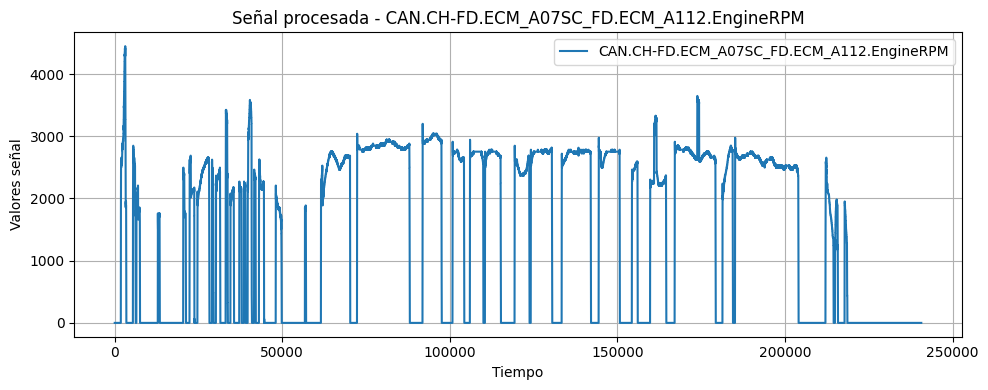

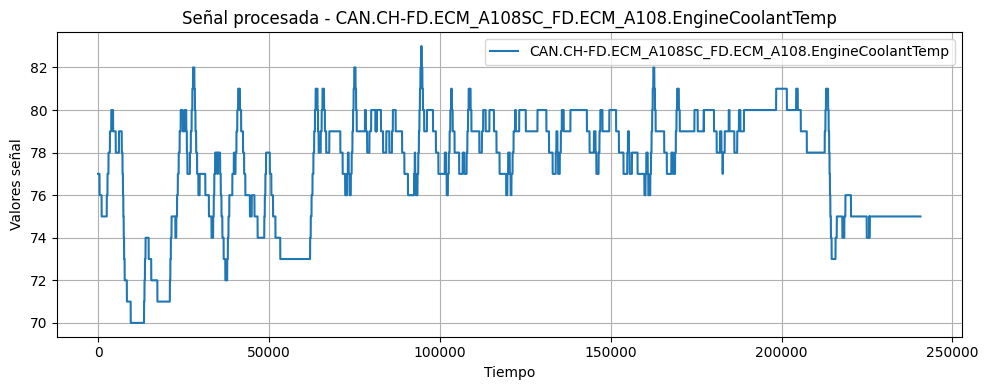

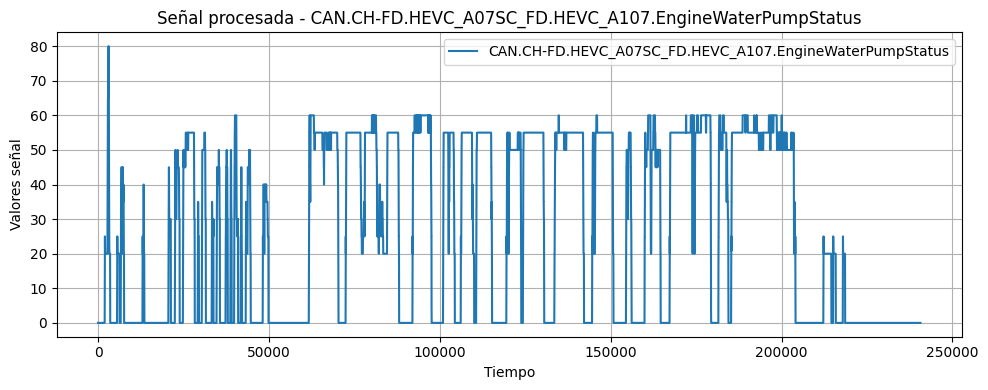

In [12]:
from asammdf import MDF
import numpy as np
import pandas as pd
import pickle

# Leer archivo MDF y filtrar canales
mdf = MDF("mf4_193da377-c9f6-404f-9f50-f1cd554860da.mf4")
channel_names = mdf.channels_db.keys()
channels_wanted = [
    "EngineRPM",
    "EngineCoolantTemp",
    "EngineWaterPumpStatus"
]
filtered_channels = [name for name in channel_names if any(name.endswith(aim) for aim in channels_wanted)]
channels_and_where = []
for channel in filtered_channels:
    where = mdf.whereis(channel)
    if where is not None:
        channels_and_where.append((channel, where[0][0], where[0][1]))

# Convertir a DataFrame interpolado
df = mdf.to_dataframe(channels=channels_and_where, time_as_date=True)

# Interpolación temporal basada en el índice de tiempo
df = df.interpolate(method='time')
# Rellenar NaNs al principio o final (donde la interpolación no alcanza)
df = df.ffill().bfill()


print(df)

# Normalizar los datos por columna (como OmniAnomaly)
X = df.to_numpy()

print("Shape del conjunto generado:", X.shape)

# Muestra las primeras señales (como entrenamiento/test visual)
import matplotlib.pyplot as plt

# Si ya tienes el DataFrame 'df' y el array X normalizado:
for i, col_name in enumerate(df.columns):
    plt.figure(figsize=(10, 4))
    plt.plot(X[:, i], label=col_name)
    plt.title(f'Señal procesada - {col_name}')
    plt.xlabel("Tiempo")
    plt.ylabel("Valores señal")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Convertir DataFrame a numpy sin normalizar
channel_names = df.columns.tolist()

# Guardar los datos crudos + nombres de columnas
with open("vehiculo_test.pkl", "wb") as f:
    pickle.dump({
        "data": X,
        "columns": channel_names
    }, f)



# Implementación personalizada de Isolation Forest con estrategias de división alternativas

En esta sección desarrollaremos una implementación propia del algoritmo **Isolation Forest**, el cual será probado sobre el dataset **SMD (Server Machine Dataset)** del trabajo **OmniAnomaly**.

A diferencia de la versión tradicional que utiliza divisiones completamente aleatorias en sus árboles (como en `sklearn.ensemble.IsolationForest`), esta implementación permitirá comparar dos estrategias de división:

- **Split aleatorio**: selección completamente aleatoria de la característica y del valor de corte, como en el algoritmo original.
- **Split basado en la distribución**: se selecciona la característica de forma aleatoria, pero el valor de corte se elige entre los valores reales de la característica, ajustándose mejor a la distribución observada de los datos.

Esta modificación permite investigar si una estrategia de división menos aleatoria pero aún eficiente puede mejorar la capacidad del modelo para detectar anomalías.

Se probarán ambas variantes usando distintas configuraciones de hiperparámetros (número de árboles, tamaño de muestra, parámetros de POT para establecer umbrales adaptativos), y se evaluarán mediante métricas estándar como **precisión, recall y F1-score**, además de visualizaciones por sensor y matriz de confusión.


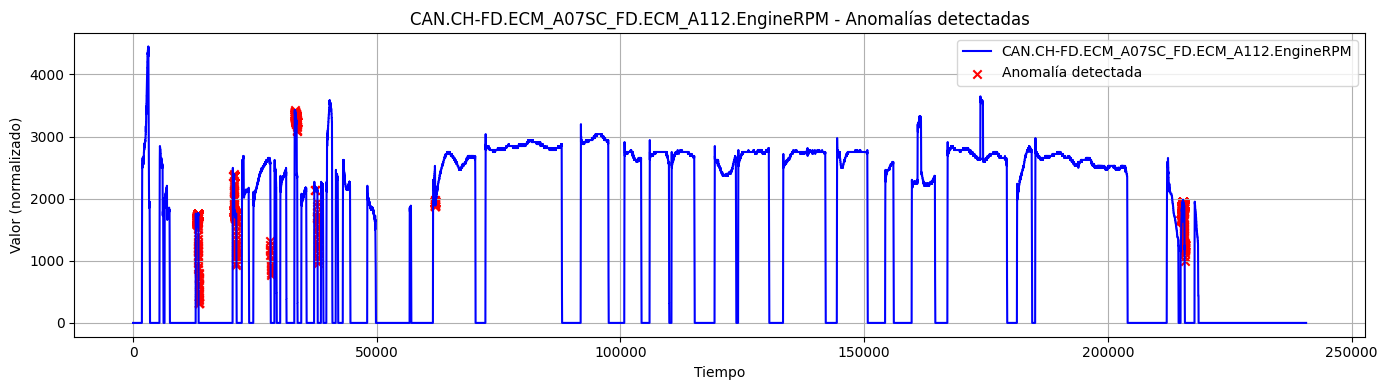

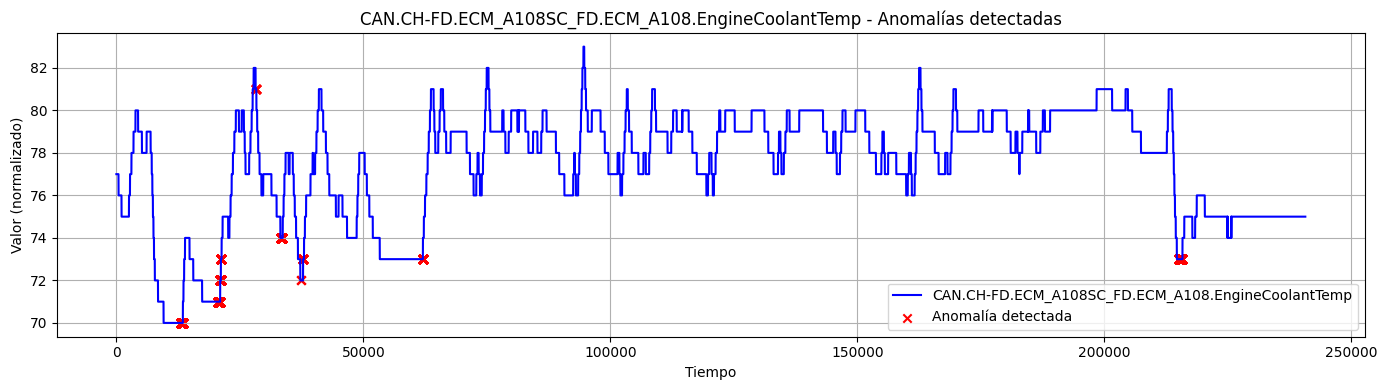

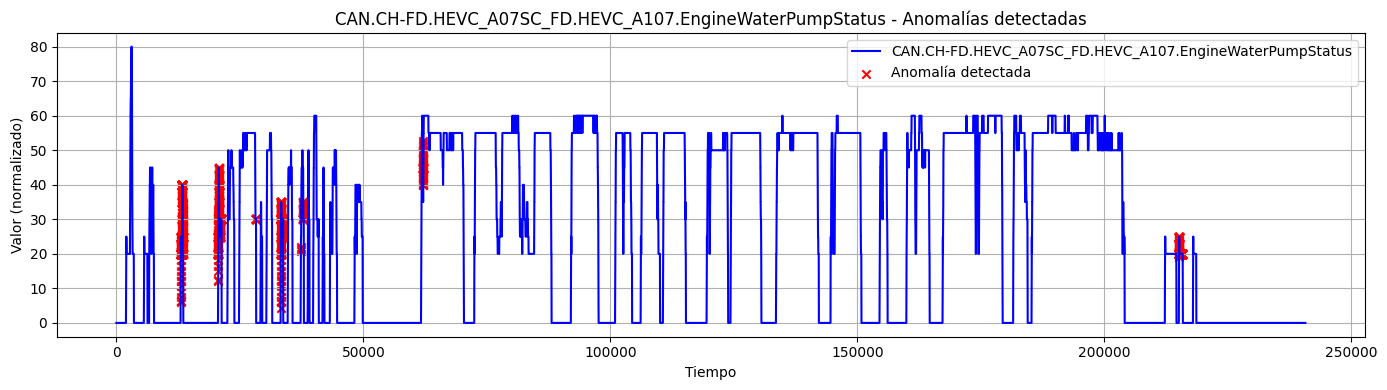

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pickle
import os
from types import SimpleNamespace

# ------------------------------
# Árbol de aislamiento
# ------------------------------
def harmonic_number(n):
    if n <= 1:
        return 0
    return np.log(n) + 0.5772156649

def c_factor(n):
    if n <= 1:
        return 0
    return 2 * harmonic_number(n - 1) - (2 * (n - 1) / n)

class iTree:
    def __init__(self, data, current_height=0, max_height=np.inf, split_selection_random=True):
        self.n_samples, self.n_features = data.shape
        self.left = None
        self.right = None
        self.split_attr = None
        self.split_value = None
        self.size = self.n_samples
        self.is_leaf = False

        if current_height >= max_height or self.n_samples <= 1:
            self.is_leaf = True
        else:
            self.split_attr = np.random.randint(self.n_features)
            min_val = np.min(data[:, self.split_attr])
            max_val = np.max(data[:, self.split_attr])

            if min_val == max_val:
                self.is_leaf = True
                return

            if split_selection_random:
                # Selección aleatoria del valor de división
                self.split_value = np.random.uniform(min_val, max_val)
            else:
                # Selección del valor de división como un valor aleatorio de la característica
                feat_values = data[:, self.split_attr]
                self.split_value = np.random.choice(feat_values)


            left_mask = data[:, self.split_attr] < self.split_value
            self.left = iTree(data[left_mask], current_height + 1, max_height, split_selection_random=split_selection_random)
            self.right = iTree(data[~left_mask], current_height + 1, max_height, split_selection_random=split_selection_random)

    def path_length(self, x, current_height=0):
        if self.is_leaf:
            return current_height + c_factor(self.size)
        if x[self.split_attr] < self.split_value:
            return self.left.path_length(x, current_height + 1)
        else:
            return self.right.path_length(x, current_height + 1)

# ------------------------------
# Bosque de aislamiento
# ------------------------------
class IsolationForest:
    def __init__(self, n_trees=100, sample_size=256, split_selection_random=True):
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.trees = []
        self.split_selection_random = split_selection_random

    def fit(self, X):
        self.trees = []
        height_limit = int(np.ceil(np.log2(self.sample_size)))
        for _ in range(self.n_trees):
            if self.sample_size < len(X):
                sample_idx = np.random.choice(len(X), self.sample_size, replace=False)
            else:
                sample_idx = np.random.choice(len(X), self.sample_size, replace=True)
            sample = X[sample_idx]
            tree = iTree(sample, current_height=0, max_height=height_limit, split_selection_random=self.split_selection_random)
            self.trees.append(tree)

    def anomaly_score(self, X):
        scores = np.zeros(len(X))
        for i, x in enumerate(X):
            path_lengths = np.array([tree.path_length(x) for tree in self.trees])
            E_h = np.mean(path_lengths)
            scores[i] = 2 ** (-E_h / c_factor(self.sample_size))
        return scores

    def predict(self, X, threshold=0.6):
        return self.anomaly_score(X) > threshold

from scipy.stats import genpareto

def apply_pot(scores, q=1e-3, level=0.98):
    """
    POT (Peak Over Threshold) para seleccionar un umbral adaptativo en scores de anomalía.
    - scores: array de valores (mayores indican mayor anomalía).
    - q: percentil para definir el umbral base (extremos).
    - level: probabilidad deseada de detección (>0.95 suele funcionar bien).
    """
    scores = np.asarray(scores)
    threshold = np.quantile(scores, 1 - q)
    extreme_vals = scores[scores > threshold] - threshold

    if len(extreme_vals) == 0:
        return threshold  # fallback si no hay extremos

    c, loc, scale = genpareto.fit(extreme_vals)
    t_pot = genpareto.ppf(level, c, loc=loc, scale=scale)
    return threshold + t_pot

# ------------------------------
# Cargar datos y ejecutar detección
# ------------------------------
with open("vehiculo_test.pkl", "rb") as f:
    loaded = pickle.load(f)
    X_raw = loaded["data"]
    channel_names = loaded["columns"]

# Normalización solo en este punto (fase de entrenamiento/inferencia)
X = (X_raw - np.mean(X_raw, axis=0)) / (np.std(X_raw, axis=0) + 1e-8)

forest = IsolationForest(n_trees=100, sample_size=64, split_selection_random=True)
forest.fit(X)
scores = forest.anomaly_score(X)
threshold = apply_pot(scores, q=0.1, level=0.92)
y_pred = (scores > threshold).astype(int)

# ------------------------------
# Visualización por sensor
# ------------------------------
for i, name in enumerate(channel_names):
    plt.figure(figsize=(14, 4))
    plt.plot(X_raw[:, i], label=f'{name}', color='blue')
    anomaly_idx = np.where(y_pred == 1)[0]
    plt.scatter(anomaly_idx, X_raw[anomaly_idx, i], color='red', label='Anomalía detectada', marker='x')
    plt.title(f'{name} - Anomalías detectadas')
    plt.xlabel("Tiempo")
    plt.ylabel("Valor (normalizado)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



## 🔍 Interpretación de los resultados de Isolation Forest

La detección de anomalías anterior se ha realizado utilizando la variante con **división aleatoria (random split)** de Isolation Forest. Esta configuración, aunque eficiente y ampliamente empleada, presenta ciertas limitaciones en términos de sensibilidad y cobertura.

Los puntos señalados como anómalos pueden interpretarse como desviaciones del comportamiento más frecuente, en línea con una definición estadística básica de anomalía. Sin embargo, al observar visualmente las señales, se perciben otros momentos en los que las variables muestran comportamientos que, **desde una perspectiva intuitiva o contextual, podrían considerarse aún más inusuales**, pero que el modelo no ha identificado como anómalos.

Esto no implica necesariamente que las detecciones sean incorrectas, sino que refleja una **limitación inherente a la simplicidad del criterio estadístico utilizado**, y nos recuerda que la noción de anomalía depende fuertemente del contexto y de los supuestos asumidos sobre lo que se considera un comportamiento "esperado".


---

A continuación, se aplicará el algoritmo sobre las mismas señales, pero esta vez utilizando la técnica alternativa basada en **divisiones informadas por los valores (value-based splits)**. Este enfoque selecciona los puntos de corte teniendo en cuenta la distribución de los datos, lo que permite generar árboles más representativos y con una **estructura de partición más fiel a la densidad real de los datos**.

Se espera que esta estrategia mejore la detección de anomalías, al capturar mejor aquellos comportamientos que, aunque no sean extremos en magnitud, sí resultan inusuales dado el contexto de las variables.



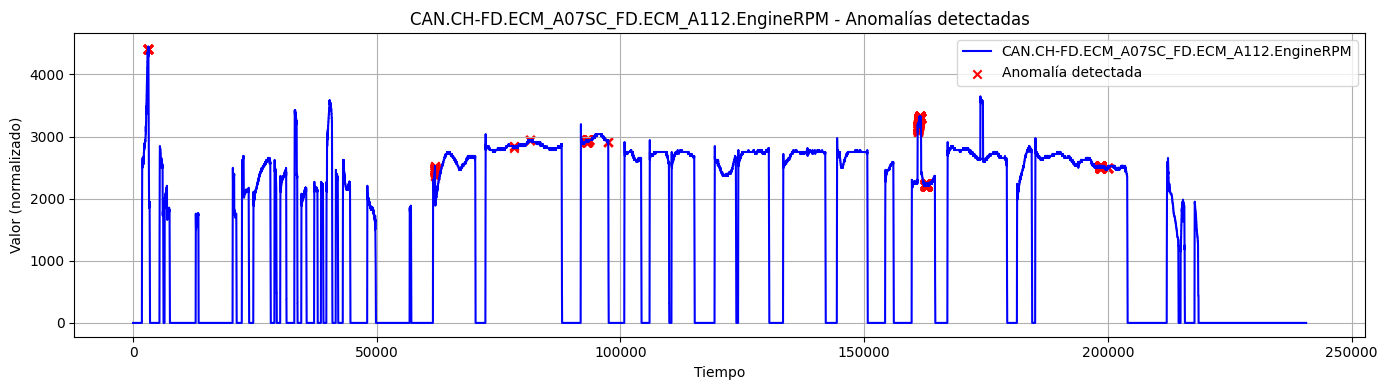

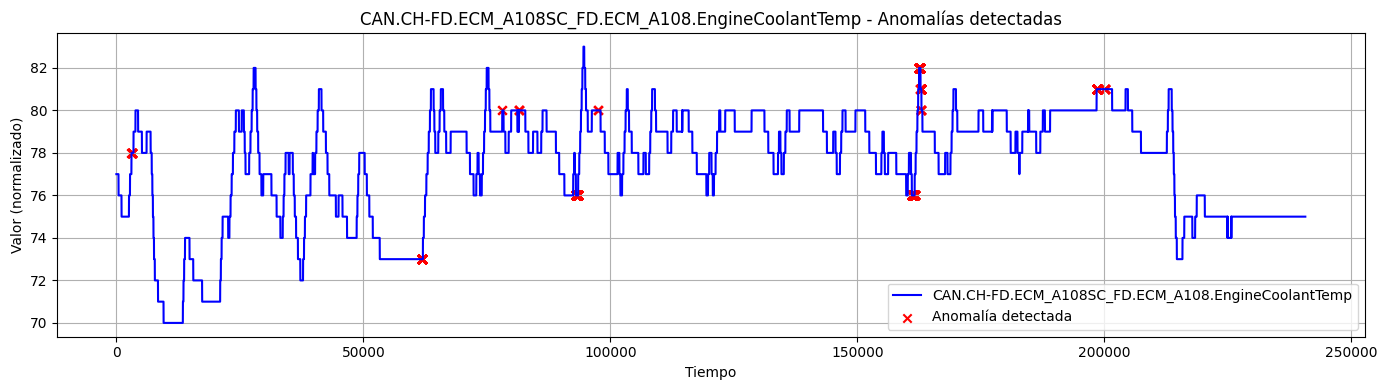

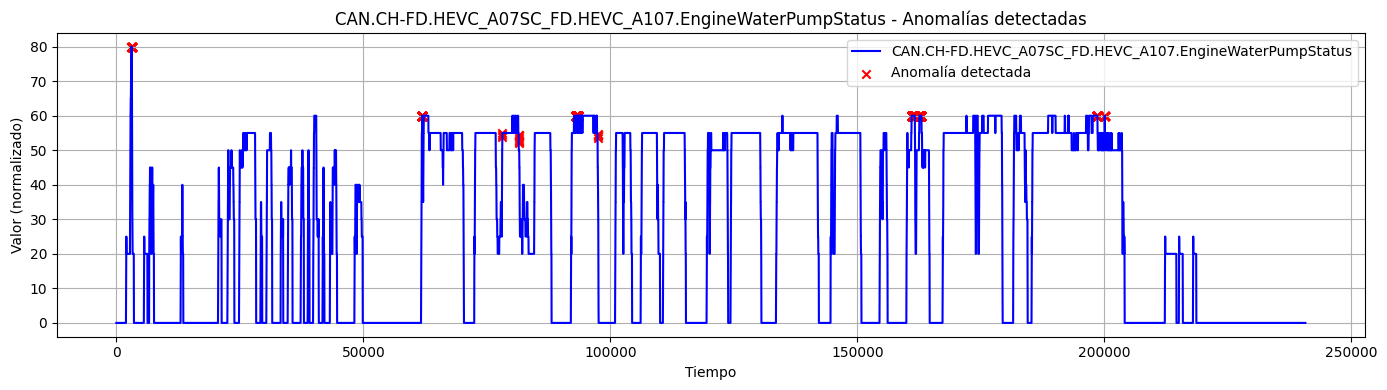

In [24]:
# ------------------------------
# Cargar datos y ejecutar detección
# ------------------------------
with open("vehiculo_test.pkl", "rb") as f:
    loaded = pickle.load(f)
    X_raw = loaded["data"]
    channel_names = loaded["columns"]

# Normalización solo en este punto (fase de entrenamiento/inferencia)
X = (X_raw - np.mean(X_raw, axis=0)) / (np.std(X_raw, axis=0) + 1e-8)

forest = IsolationForest(n_trees=100, sample_size=64, split_selection_random=False)
forest.fit(X)
scores = forest.anomaly_score(X)
threshold = apply_pot(scores, q=0.1, level=0.92)
y_pred = (scores > threshold).astype(int)

# ------------------------------
# Visualización por sensor
# ------------------------------
for i, name in enumerate(channel_names):
    plt.figure(figsize=(14, 4))
    plt.plot(X_raw[:, i], label=f'{name}', color='blue')
    anomaly_idx = np.where(y_pred == 1)[0]
    plt.scatter(anomaly_idx, X_raw[anomaly_idx, i], color='red', label='Anomalía detectada', marker='x')
    plt.title(f'{name} - Anomalías detectadas')
    plt.xlabel("Tiempo")
    plt.ylabel("Valor (normalizado)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 🔎 Evaluación del enfoque con divisiones basadas en valores

Tras aplicar el algoritmo utilizando la técnica alternativa basada en **divisiones informadas por los valores (value-based splits)**, se aprecia una **ligera mejora** en la detección de anomalías.

Aunque el modelo sigue realizando detecciones puntuales y locales —como es inherente al funcionamiento de Isolation Forest—, en esta ocasión parece captar de manera algo más acertada ciertos comportamientos inusuales. Esto sugiere que, al tener en cuenta la distribución real de los datos al realizar los cortes, los árboles generados reflejan mejor la estructura del espacio de características.

En consecuencia, el modelo parece mostrar **una mayor sensibilidad ante desviaciones sutiles**, lo que puede interpretarse como una mejor comprensión de la densidad y forma del conjunto de datos. No obstante, la detección sigue estando limitada por la naturaleza del algoritmo, centrado en el aislamiento estadístico más que en relaciones contextuales o temporales.

## 🧪 Prueba adicional: enriquecer el modelo con dinámica temporal

Como prueba complementaria, se explorará la posibilidad de que Isolation Forest pueda captar **comportamientos más ricos que simples valores puntuales**, incorporando información sobre la dinámica del sistema.

Para ello, se enriquecerá el conjunto de datos añadiendo:

- **Deltas (primera derivada):** cambios entre un instante y el anterior.
- **Aceleración (segunda derivada):** cambios en la velocidad de variación.

Estas variables adicionales permiten describir no solo *en qué estado está el sistema*, sino también *cómo está evolucionando*. De este modo, se busca que el algoritmo tenga una representación más completa del contexto de cada observación, aumentando así su capacidad para detectar anomalías que no sean necesariamente extremos absolutos, sino comportamientos inusuales en la evolución de las señales.

Los datos enriquecidos serán utilizados como entrada del modelo, manteniendo el mismo procedimiento de detección con Isolation Forest.

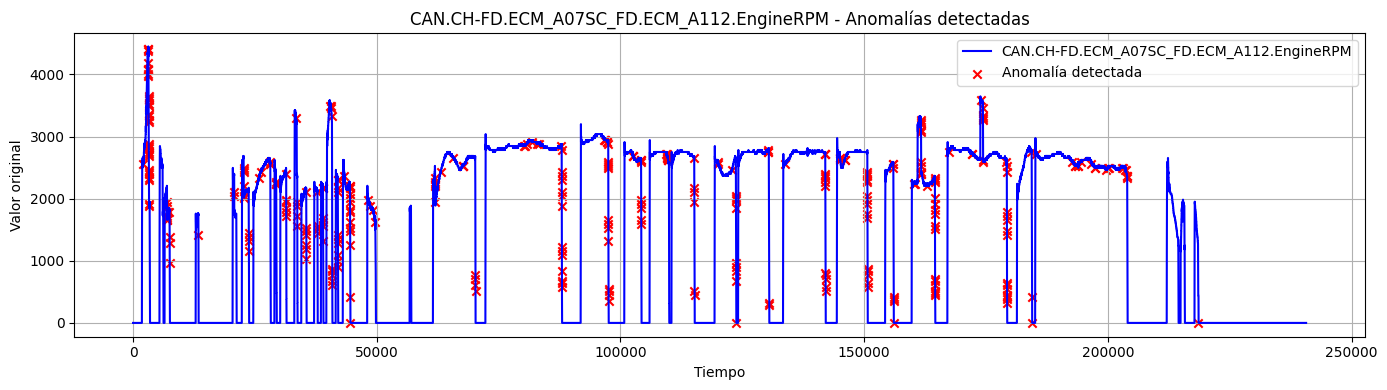

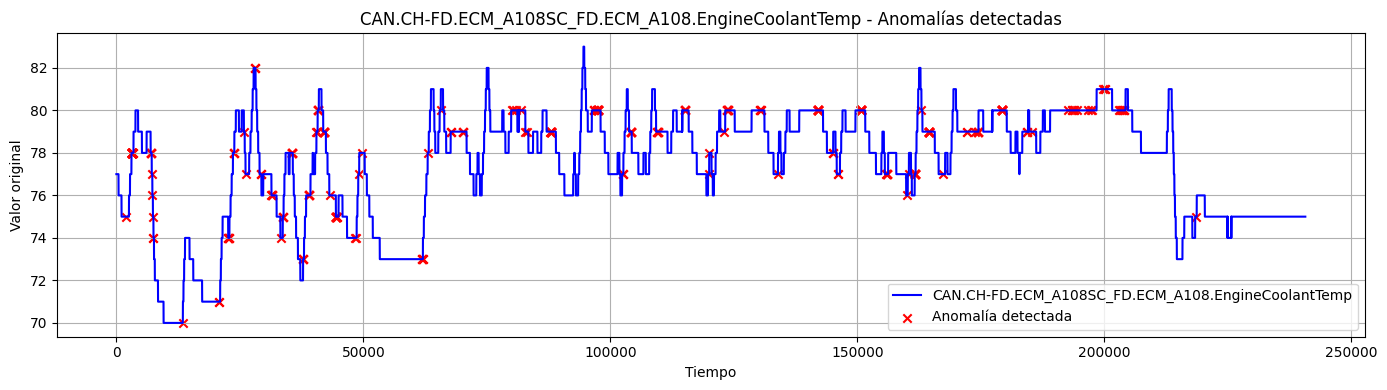

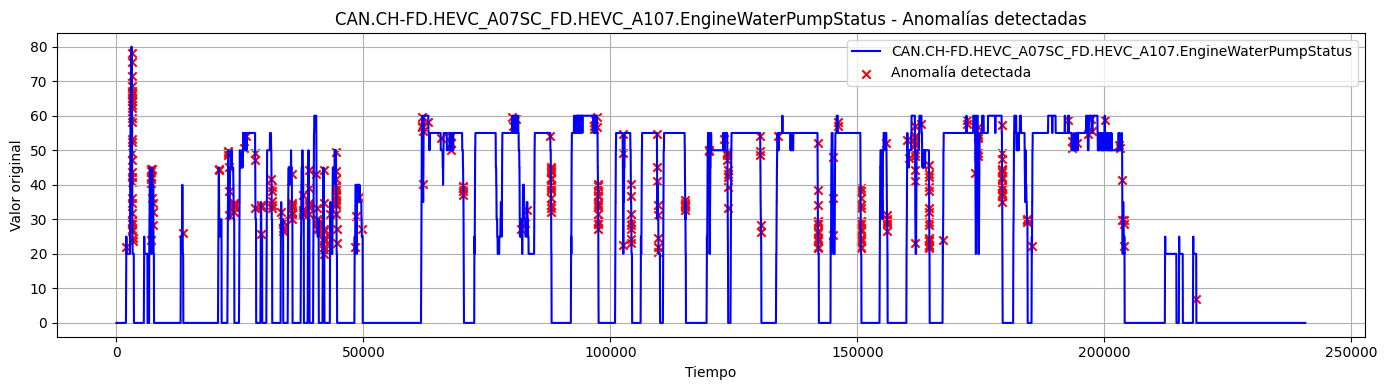

In [26]:
# ------------------------------
# Cargar datos y ejecutar detección
# ------------------------------
with open("vehiculo_test.pkl", "rb") as f:
    loaded = pickle.load(f)
    X_raw = loaded["data"]
    channel_names = loaded["columns"]

# Convertir a DataFrame para facilitar el cálculo de derivadas
df_raw = pd.DataFrame(X_raw, columns=channel_names)

# Calcular deltas (primera derivada) y aceleración (segunda derivada)
df_delta = df_raw.diff().fillna(0)
df_accel = df_raw.diff().diff().fillna(0)

# Concatenar valores originales + deltas + aceleraciones
df_enriched = pd.concat([df_raw, df_delta, df_accel], axis=1)
enriched_feature_names = (
    [f'{col}_val' for col in channel_names] +
    [f'{col}_delta' for col in channel_names] +
    [f'{col}_accel' for col in channel_names]
)
df_enriched.columns = enriched_feature_names

# Normalización
X = df_enriched.to_numpy()
X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-8)

# Entrenar Isolation Forest
forest = IsolationForest(n_trees=100, sample_size=64, split_selection_random=False)
forest.fit(X)
scores = forest.anomaly_score(X)
threshold = apply_pot(scores, q=0.1, level=0.99)
y_pred = (scores > threshold).astype(int)

# ------------------------------
# Visualización por sensor original
# ------------------------------
for i, name in enumerate(channel_names):
    plt.figure(figsize=(14, 4))
    plt.plot(X_raw[:, i], label=f'{name}', color='blue')
    anomaly_idx = np.where(y_pred == 1)[0]
    plt.scatter(anomaly_idx, X_raw[anomaly_idx, i], color='red', label='Anomalía detectada', marker='x')
    plt.title(f'{name} - Anomalías detectadas')
    plt.xlabel("Tiempo")
    plt.ylabel("Valor original")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 🧪 Evaluación del enriquecimiento dinámico: deltas y aceleración

Tras incorporar información adicional en forma de **deltas** (primeras derivadas) y **aceleraciones** (segundas derivadas) como parte del conjunto de entrada, los resultados iniciales muestran que, **con los mismos parámetros utilizados previamente para la función POT**, el rendimiento del modelo **parece empeorar**.

A primera vista, el modelo muestra una tendencia a **detectar más puntos como anómalos**, incluyendo situaciones que quizá no lo sean tanto. Esto puede interpretarse como un aumento en la sensibilidad del modelo, aunque también puede reflejar un incremento del ruido o una pérdida de precisión en la detección.

Sin embargo, al ajustar los parámetros de la función POT (por ejemplo, elevando el umbral de activación), la calidad de las detecciones mejora, y emerge una sensación de que el modelo **es menos conservador y se atreve a señalar patrones que, aunque no claramente extremos, resultan inusuales en su evolución**. Esto sugiere que el enriquecimiento con dinámica temporal podría aportar valor, pero requiere **una recalibración cuidadosa de los umbrales de decisión**.

---



## 🧩 Conclusión general sobre el uso de Isolation Forest en este contexto

A lo largo de las distintas pruebas, se han explorado varias formas de aplicar Isolation Forest sobre señales multivariadas:

- **Divisiones aleatorias**: rápidas y eficaces, pero limitadas en cobertura.
- **Divisiones basadas en valores**: ligeramente más precisas al reflejar mejor la distribución real de los datos.
- **Datos enriquecidos con deltas y aceleración**: aportan contexto temporal, aunque requieren una reevaluación de los umbrales de detección para evitar sobredetección o falsos positivos.

Estas observaciones subrayan que Isolation Forest, aunque potente como detector estadístico de outliers, **debe ser cuidadosamente ajustado y enriquecido cuando se aplica a problemas complejos como la detección de anomalías en series temporales**, donde las relaciones temporales y contextuales juegan un papel central.

---

Dentro del ámbito que estamos tratando —la **detección de anomalías en una fase inicial del proyecto**, donde el enfoque debe ser **no supervisado y sin retroalimentación por parte de expertos**—, esta técnica representa una **primera aproximación válida**. Permite una exploración inicial del comportamiento de las señales y la identificación preliminar de eventos inusuales.

En el próximo capítulo se abordará una estrategia diferente: **la aplicación de modelos ocultos de Markov (HMM)** sobre datos de señales extraídos de archivos MDF, con el objetivo de capturar estructuras temporales más complejas y patrones de transición entre estados.
